In [5]:



import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf




In [6]:
train_dir = Path('C:\\Users\\Selva\\Desktop\\fruits prediction\\train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

In [7]:
test_dir = Path('C:\\Users\\Selva\\Desktop\\fruits prediction\\test')
test_filepaths = list(test_dir.glob(r'*/*.jpg'))

In [8]:
val_dir = Path('C:\\Users\\Selva\\Desktop\\fruits prediction\\validation')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [9]:
import os

In [12]:


def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """
    labels = []
    for i in range(len(filepath)):
        path_parts = str(filepath[i]).split(os.sep)  # Use os.sep for cross-platform compatibility
        if len(path_parts) > 1:  # Ensure there are enough parts in the split path
            labels.append(path_parts[-2])  # Get the parent directory as the label
        else:
            labels.append("Unknown")  # Handle edge cases where path is malformed
    
    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    df = pd.concat([filepath, labels], axis=1)
    df = df.sample(frac=1).reset_index(drop=True)

    return df


In [13]:
train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

In [14]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 2855

Number of different labels: 36

Labels: ['soy beans' 'apple' 'chilli pepper' 'pineapple' 'lettuce' 'corn'
 'cucumber' 'banana' 'tomato' 'cauliflower' 'paprika' 'peas' 'turnip'
 'beetroot' 'raddish' 'capsicum' 'mango' 'sweetcorn' 'lemon' 'onion'
 'orange' 'garlic' 'spinach' 'sweetpotato' 'jalepeno' 'pomegranate'
 'watermelon' 'bell pepper' 'grapes' 'pear' 'cabbage' 'kiwi' 'eggplant'
 'potato' 'carrot' 'ginger']


In [16]:
train_df.head(5)

Filepath          Label
0  C:\Users\Selva\Desktop\fruits prediction\train...      soy beans
1  C:\Users\Selva\Desktop\fruits prediction\train...          apple
2  C:\Users\Selva\Desktop\fruits prediction\train...  chilli pepper
3  C:\Users\Selva\Desktop\fruits prediction\train...      pineapple
4  C:\Users\Selva\Desktop\fruits prediction\train...        lettuce

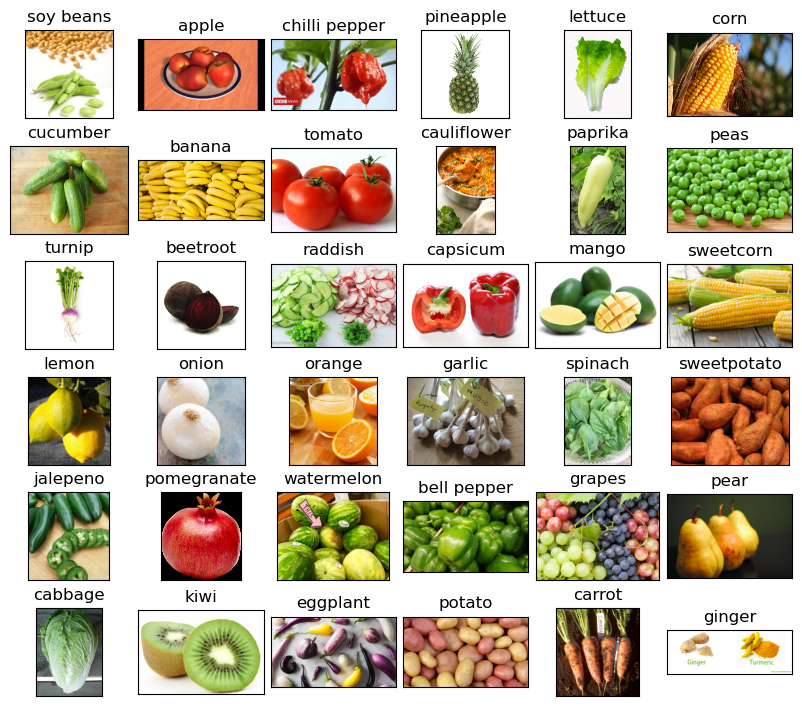

In [17]:
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [18]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2855 validated image filenames belonging to 36 classes.
Found 340 validated image filenames belonging to 36 classes.
Found 340 validated image filenames belonging to 36 classes.


In [19]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [20]:
inputs = pretrained_model.input

In [21]:
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

In [22]:
outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

In [23]:
outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

In [24]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [25]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5


c:\Users\Selva\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


90/90 ━━━━━━━━━━━━━━━━━━━━ 295s 3s/step - accuracy: 0.3289 - loss: 2.6090 - val_accuracy: 0.8353 - val_loss: 0.5687
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 245s 3s/step - accuracy: 0.8117 - loss: 0.6109 - val_accuracy: 0.8824 - val_loss: 0.3520
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.8970 - loss: 0.3361 - val_accuracy: 0.9353 - val_loss: 0.2491
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 278s 3s/step - accuracy: 0.9254 - loss: 0.2309 - val_accuracy: 0.9235 - val_loss: 0.2673
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 236s 3s/step - accuracy: 0.9553 - loss: 0.1589 - val_accuracy: 0.9412 - val_loss: 0.2045


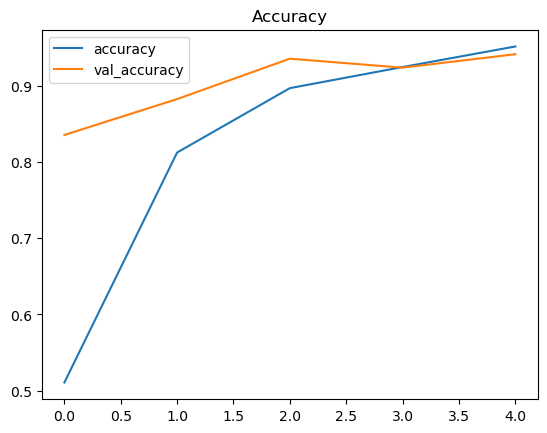

In [26]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

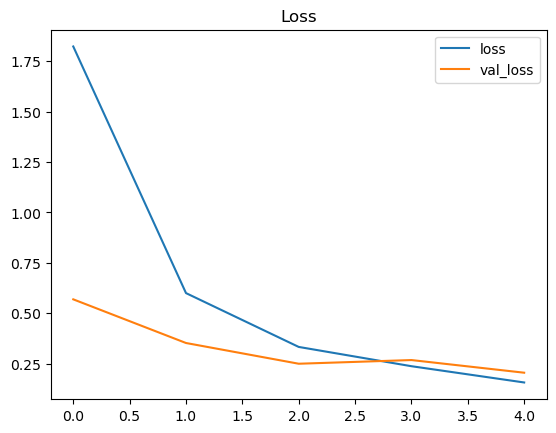

In [27]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [28]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

c:\Users\Selva\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step


In [29]:
labels.items()

dict_items([(0, 'apple'), (1, 'banana'), (2, 'beetroot'), (3, 'bell pepper'), (4, 'cabbage'), (5, 'capsicum'), (6, 'carrot'), (7, 'cauliflower'), (8, 'chilli pepper'), (9, 'corn'), (10, 'cucumber'), (11, 'eggplant'), (12, 'garlic'), (13, 'ginger'), (14, 'grapes'), (15, 'jalepeno'), (16, 'kiwi'), (17, 'lemon'), (18, 'lettuce'), (19, 'mango'), (20, 'onion'), (21, 'orange'), (22, 'paprika'), (23, 'pear'), (24, 'peas'), (25, 'pineapple'), (26, 'pomegranate'), (27, 'potato'), (28, 'raddish'), (29, 'soy beans'), (30, 'spinach'), (31, 'sweetcorn'), (32, 'sweetpotato'), (33, 'tomato'), (34, 'turnip'), (35, 'watermelon')])

In [30]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 94.12%


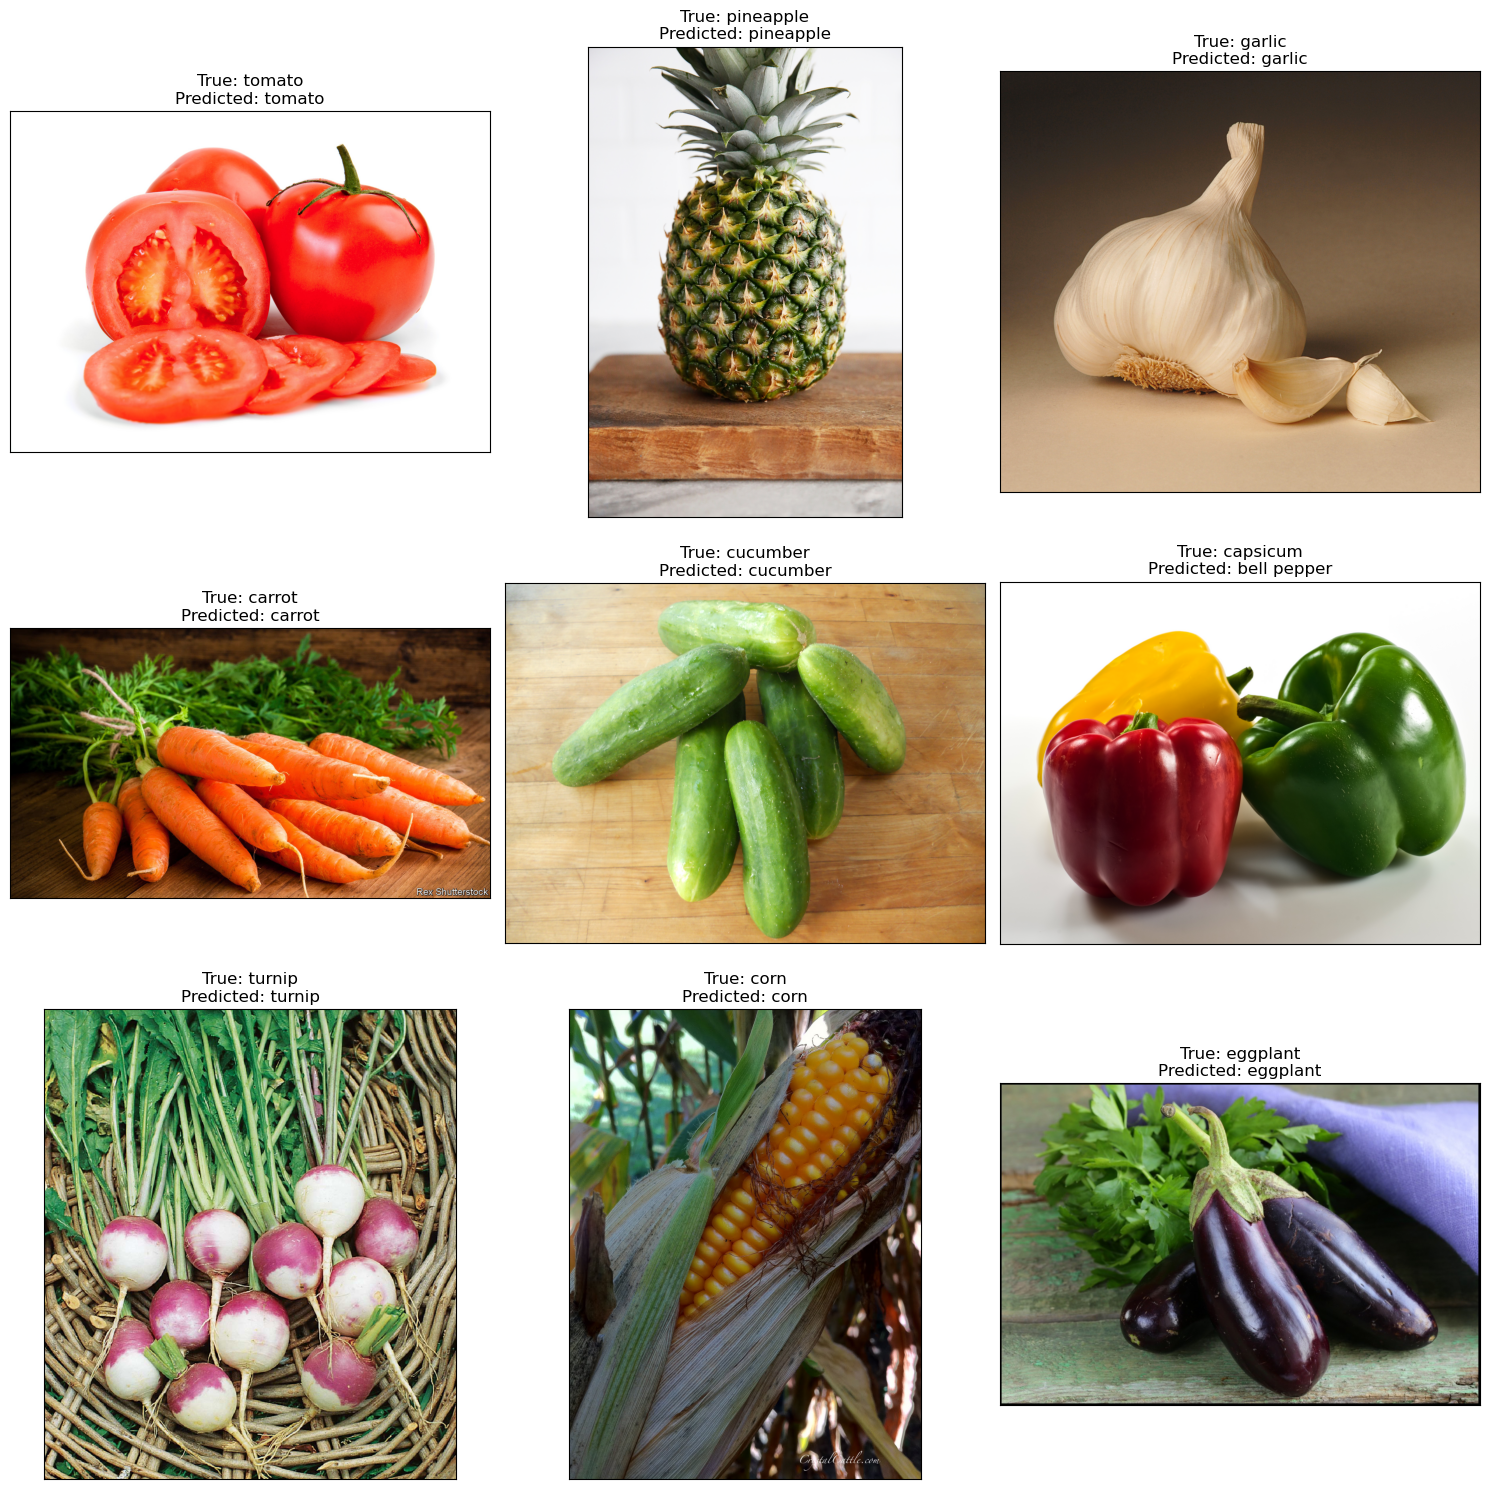

In [31]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [32]:
def output(location):
    from tensorflow.keras.preprocessing.image import load_img,img_to_array
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

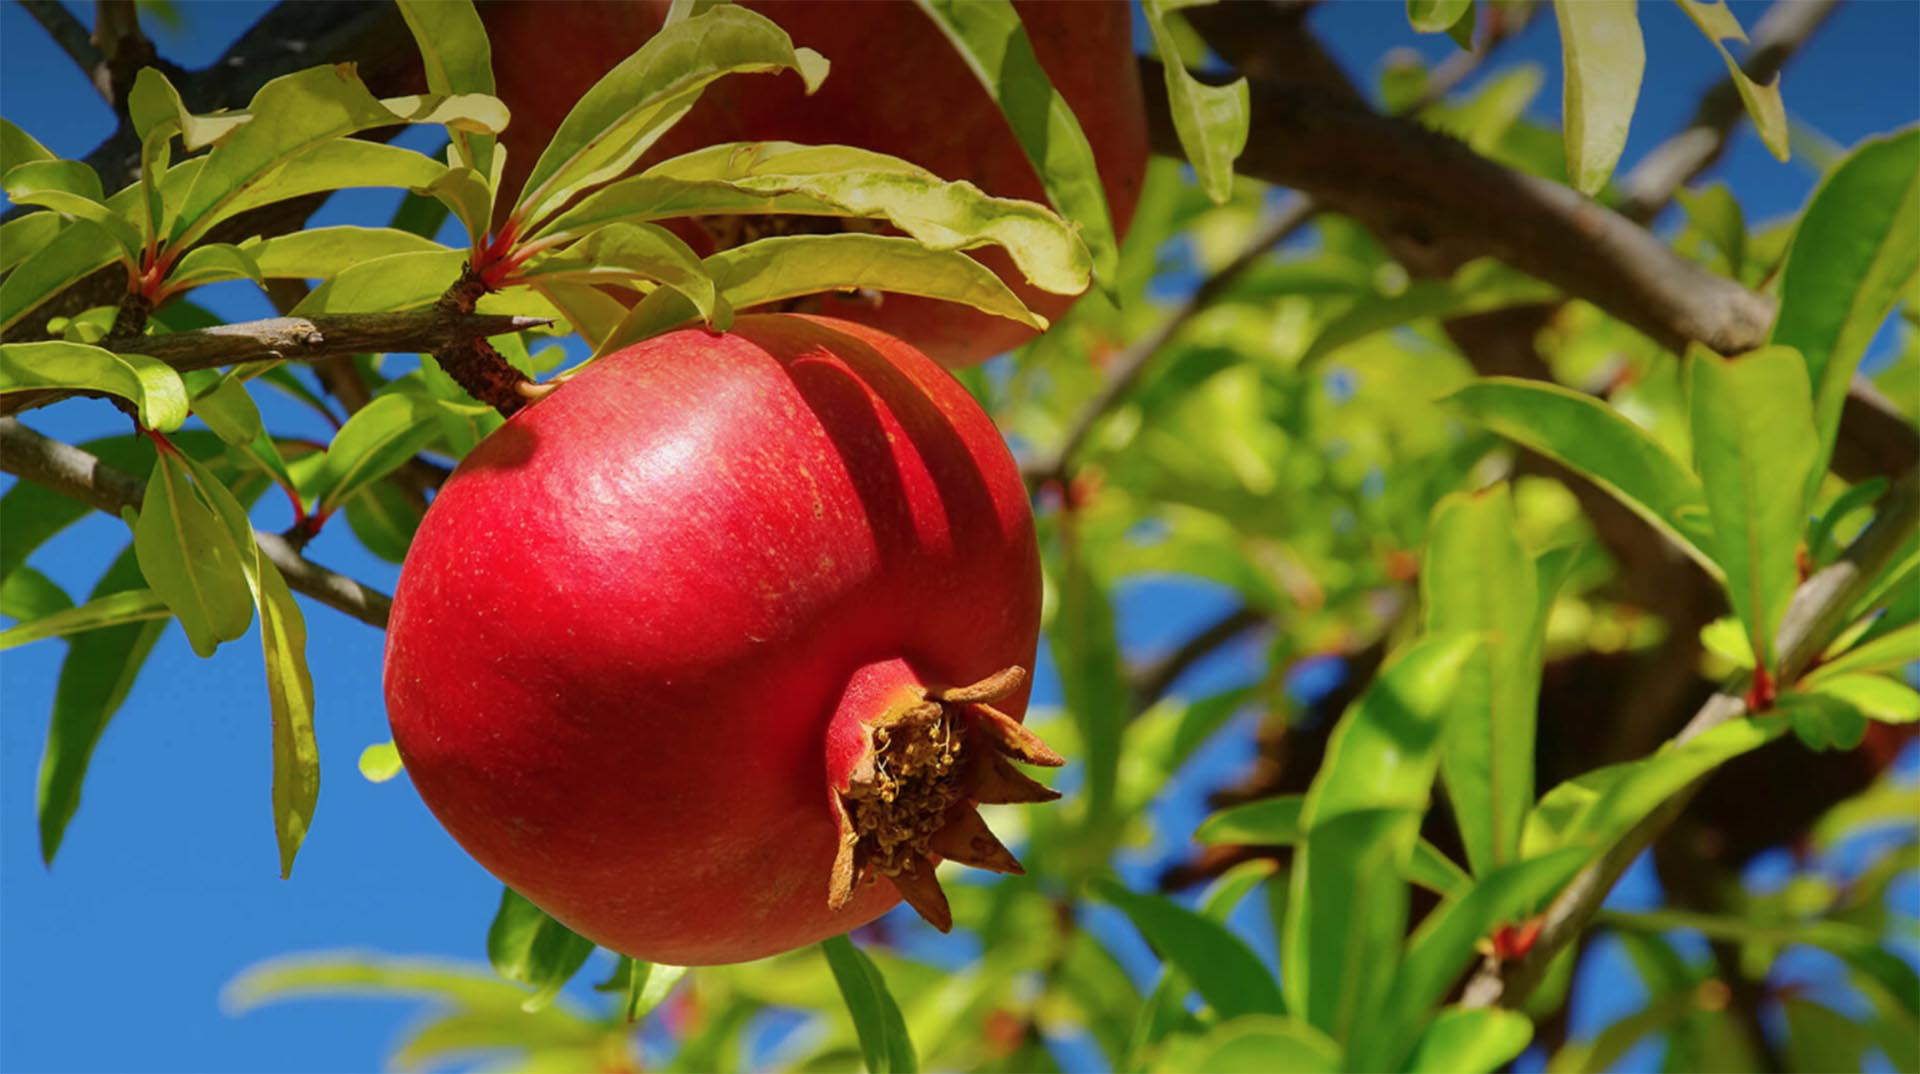

In [37]:
from IPython.display import display
from PIL import Image

location = 'C:\\Users\\Selva\\Desktop\\fruits prediction\\test\\pomegranate\\Image_4.jpg'
display(Image.open(location))

In [38]:
img = output(location)
img

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


'pomegranate'